Load the model and the vectorizer

In [30]:
from google.colab import drive
import joblib
import pandas as pd
import re

# 1. Mount your Google Drive to access the saved files
drive.mount('/content/drive', force_remount=True)

# 2. Define the path where your model is saved
model_folder_path = '/content/drive/My Drive/Monatea_Cafe/'
model_file = f"{model_folder_path}expense_model.joblib"
vectorizer_file = f"{model_folder_path}tfidf_vectorizer.joblib"

# 3. Load the pre-trained model and vectorizer using the correct path
try:
    print(f"Attempting to load model from: {model_file}")
    loaded_model = joblib.load(model_file)

    print(f"Attempting to load vectorizer from: {vectorizer_file}")
    loaded_vectorizer = joblib.load(vectorizer_file)

    print("\n✅ Model and vectorizer loaded successfully.")

except FileNotFoundError:
    print("\n🛑 Error: File not found. Please double-check the folder and file names.")
    print(loaded_model)
    print(loaded_vectorizer)

Mounted at /content/drive
Attempting to load model from: /content/drive/My Drive/Monatea_Cafe/expense_model.joblib
Attempting to load vectorizer from: /content/drive/My Drive/Monatea_Cafe/tfidf_vectorizer.joblib

✅ Model and vectorizer loaded successfully.


We are able to load our Machine Learning trained model and the Vectorizer, now we will access the data from our google sheets that the manager input the daily revenue

First we have to authenticate with the Google login and permission

In [31]:
import gspread
from google.colab import auth
from google.auth import default

# --- Authenticate with Google ---

auth.authenticate_user()

creds, _ = default()

gc = gspread.authorize(creds)



print("✅ Authentication successful.")

✅ Authentication successful.


Then we will access the spreadsheet to retrieve the data from columns. Notice that I have made a copy with all realistic mockup data to respect the Coffee Shop confidential data

In [32]:
# --- Load the raw notes from your Google Sheet ---
try:
    spreadsheet = gc.open("Bản Sao Bảo Mật - Báo Cáo Tổng Doanh Thu") # Open the Google Sheet from the client
    worksheet = spreadsheet.worksheet("Bảng Báo Cáo Chính") # Go to the work sheet that contain the data

    # Getting data from the correct column, ignore the first row which is the header
    raw_notes_from_sheet = worksheet.col_values(8)[1:]
    raw_revenue_data = worksheet.col_values(3)[1:]
    raw_transfer_revenue = worksheet.col_values(4)[1:]
    raw_cash_revenue = worksheet.col_values(5)[1:]

    print(f"\n✅ Successfully extracted {len(raw_notes_from_sheet)} notes from Google Sheets.")

except gspread.exceptions.SpreadsheetNotFound:
    print("Error: Spreadsheet not found. Please check the name and sharing settings.")
    raw_notes_from_sheet = [] # Use empty list to avoid crash



✅ Successfully extracted 14 notes from Google Sheets.


Quickly checking the data we have imported

In [33]:
raw_notes_from_sheet

['Dán bảng (380k)\nTrả tiền A( 1tr140k)\nTrả tiền nhân viên B (760k)\n',
 '',
 'mua chuối 500g\nmua dâu 1kg\nTổng 209k\n',
 'tiền đá sạch (30k)',
 '',
 'tiền hoa tươi (140k)\nTiền đường, giấy (217k)',
 'tiền đá (30k)\nNguyên liệu (963k)\nTiền sửa xe (500k)\n',
 'tiền đá,đường phèn,chai xịt muỗi (110k)',
 'tiền khung tranh (90k ck)\ntiền đổ xăng (100k ck )\ntiền nạp đt (30k ck )\ntiền ăn (325k ck )\ntiền nguyên liệu (726k ck )\ntiền marketing (500k ck )',
 'Tiền ăn của như vs nhân viên 3 ngày (220k).                                                              Tiền đá (30k).                                                     Nước rửa kính, chai xịt phòng WC (78k).                                                    Tiền kệ bánh (600k).',
 '',
 'Tiền bác bảo vệ (600k)',
 'Tiền hoa (40k)',
 'Tiền bảo trì máy pha cà phê (1tr)']

In [34]:
raw_revenue_data

['657,000 ₫',
 '980,000 ₫',
 '689,000 ₫',
 '141,000 ₫',
 '1,506,000 ₫',
 '2,305,000 ₫',
 '2,480,000 ₫',
 '774,000 ₫',
 '684,000 ₫',
 '587,000 ₫',
 '890,000 ₫',
 '1,124,000 ₫',
 '2,540,000 ₫',
 '2,869,000 ₫']

In [35]:
raw_cash_revenue

['460,000 ₫',
 '568,000 ₫',
 '350,000 ₫',
 '68,000 ₫',
 '890,000 ₫',
 '1,689,000 ₫',
 '1,560,000 ₫',
 '423,000 ₫',
 '433,000 ₫',
 '333,000 ₫',
 '246,000 ₫',
 '985,000 ₫',
 '1,985,000 ₫',
 '1,853,000 ₫']

We define some helper function to extract the information from the note column, format it in a way that we can use the data (by removing commas, spaces)

Also we will have a data cleaning function to make sure the data is in the correct format to work with

In [36]:
# All helper functions:

def extract_info(note):
    """Uses Regex to extract the description and amount from a raw note."""
    # This pattern now handles "tr" for triệu (million) and "k" for thousand
    match = re.search(r'(.+?)\s*\((.+?)\)', note)
    if not match:
        return note.strip(), 0

    description = match.group(1).strip()
    amount_str = match.group(2).lower()

    amount = 0
    if 'tr' in amount_str:
        amount = float(re.sub(r'[^0-9.]', '', amount_str.replace('tr', '.'))) * 1000000
    elif 'k' in amount_str:
        amount = float(re.sub(r'[^0-9.]', '', amount_str)) * 1000

    return description, int(amount)

def create_keyword_list (dictionary):
  all_keywords = []
  for keyword_list in dictionary.values():
    for keyword in keyword_list:
      all_keywords.append(keyword)
  return all_keywords

# A function to find the category for a single note
def categorize_note(note, rules):
  note_lower = note.lower()
  for category, keywords in rules.items():
    for keyword in keywords:
      if keyword in note_lower:
        return category
  return 'Tiền khác'

# A function that clean the data
def clean_expense_notes(raw_data):
  """
  Cleans a list of strings from a Google Sheet column.

  It handles items with multiple lines (separated by '\n' or '.)
  and removes any empty entries.

  Args:
    raw_notes_from_sheet: A list of strings, where each string is a cell's value.

  Returns:
    A clean list of strings, where each string is a single expense note.
  """
  clean_notes = []

  for item in raw_notes_from_sheet:
      # First, handle the special case with periods and lots of spaces
      # by replacing the period-delimiter with a newline, and strip whitespace
      cleaned_item = item.replace(').', ')\n').strip()

      # Split the item into individual lines based on the newline character
      lines = cleaned_item.split('\n')

      # Loop through the resulting lines
      for line in lines:
          # Check if the line is not empty after stripping whitespace
          if line.strip():
              # Add the clean line to our final list
              clean_notes.append(line.strip())

  return clean_notes

def convert_currency_to_number (raw_data):
  """
  Cleans a currency string (e.g., "510,000 ₫") and converts it to a number.

  Args:
    currency_string: The string to convert.

  Returns:
    An integer representation of the currency, or 0 if conversion fails.
  """

  try:
    clean_string = raw_data.replace(' ', '').replace('₫', '').replace(',', '').strip()
    return int(clean_string)
  except ValueError:
    return 0

The next step is to clean the raw data with the helper functions, then we will the clean data to calculate the sum of revenue, the sum of money transfered and the sum of cash

In [37]:
# Clean data
clean_data = clean_expense_notes(raw_notes_from_sheet)

clean_revenue = [convert_currency_to_number(item) for item in raw_revenue_data]
clean_transfer = [convert_currency_to_number(item) for item in raw_transfer_revenue]
clean_cash = [convert_currency_to_number(item) for item in raw_cash_revenue]

print(f"Cleaned Data: {clean_data}")
print(f"Cleaned Revenue Data: {clean_revenue}")
print(f"Cleaned Transfer Data: {clean_transfer}")
print(f"Cleaned Cash Data: {clean_cash}")

total_revenue = sum(clean_revenue)
total_transfer = sum(clean_transfer)
total_cash = sum(clean_cash)

total_profit = total_revenue - total_transfer - total_cash

print(f"Tổng Doanh Thu: {total_revenue}")
print(f"Tổng Chuyển Khoản/Thẻ: {total_transfer}")
print(f"Tổng Tiền Mặt: {total_cash}")

Cleaned Data: ['Dán bảng (380k)', 'Trả tiền A( 1tr140k)', 'Trả tiền nhân viên B (760k)', 'mua chuối 500g', 'mua dâu 1kg', 'Tổng 209k', 'tiền đá sạch (30k)', 'tiền hoa tươi (140k)', 'Tiền đường, giấy (217k)', 'tiền đá (30k)', 'Nguyên liệu (963k)', 'Tiền sửa xe (500k)', 'tiền đá,đường phèn,chai xịt muỗi (110k)', 'tiền khung tranh (90k ck)', 'tiền đổ xăng (100k ck )', 'tiền nạp đt (30k ck )', 'tiền ăn (325k ck )', 'tiền nguyên liệu (726k ck )', 'tiền marketing (500k ck )', 'Tiền ăn của như vs nhân viên 3 ngày (220k)', 'Tiền đá (30k)', 'Nước rửa kính, chai xịt phòng WC (78k)', 'Tiền kệ bánh (600k)', 'Tiền bác bảo vệ (600k)', 'Tiền hoa (40k)', 'Tiền bảo trì máy pha cà phê (1tr)']
Cleaned Revenue Data: [657000, 980000, 689000, 141000, 1506000, 2305000, 2480000, 774000, 684000, 587000, 890000, 1124000, 2540000, 2869000]
Cleaned Transfer Data: [197000, 412000, 339000, 73000, 616000, 616000, 920000, 351000, 251000, 254000, 644000, 139000, 555000, 1016000]
Cleaned Cash Data: [460000, 568000, 350

Then we will process each note using our ML model to predict the category

In [38]:
# --- Process each note using the ML model ---
processed_data = []
clean_data = clean_expense_notes(raw_notes_from_sheet)

for note in clean_data:
    if note.strip():
        # Step 1: Clean the raw note
        description, amount = extract_info(note)

        # Step 2: Use the TRAINED ML model to predict the category
        description_vectorized = loaded_vectorizer.transform([description])
        predicted_category = loaded_model.predict(description_vectorized)[0]

        processed_data.append({
            "Description": description,
            "Amount": amount,
            "Category": predicted_category
        })

In [39]:
# Create the final DataFrame
final_df = pd.DataFrame(processed_data)
final_df

,Description,Amount,Category
0,Dán bảng,380000,Nguyên liệu & Thực phẩm
1,Trả tiền A,1140000,Tiền nhân viên
2,Trả tiền nhân viên B,760000,Tiền nhân viên
3,mua chuối 500g,0,Nguyên liệu & Thực phẩm
4,mua dâu 1kg,0,Nguyên liệu & Thực phẩm
5,Tổng 209k,0,Nguyên liệu & Thực phẩm
6,tiền đá sạch,30000,Vật tư & Thiết bị
7,tiền hoa tươi,140000,Nguyên liệu & Thực phẩm
8,"Tiền đường, giấy",217000,Nguyên liệu & Thực phẩm
9,tiền đá,30000,Vật tư & Thiết bị


In [40]:
print("\n--- Cleaned & Categorized Data ---")
print(final_df.to_string())

# Group by the predicted category and sum the amounts
category_totals = final_df.groupby('Category')['Amount'].sum().sort_values(ascending=False)

print("\n--- Total Spending by Predicted Category ---")
print(category_totals)


--- Cleaned & Categorized Data ---
                            Description   Amount                 Category
0                              Dán bảng   380000  Nguyên liệu & Thực phẩm
1                            Trả tiền A  1140000           Tiền nhân viên
2                  Trả tiền nhân viên B   760000           Tiền nhân viên
3                        mua chuối 500g        0  Nguyên liệu & Thực phẩm
4                           mua dâu 1kg        0  Nguyên liệu & Thực phẩm
5                             Tổng 209k        0  Nguyên liệu & Thực phẩm
6                          tiền đá sạch    30000        Vật tư & Thiết bị
7                         tiền hoa tươi   140000  Nguyên liệu & Thực phẩm
8                      Tiền đường, giấy   217000  Nguyên liệu & Thực phẩm
9                               tiền đá    30000        Vật tư & Thiết bị
10                          Nguyên liệu   963000  Nguyên liệu & Thực phẩm
11                          Tiền sửa xe   500000        Bảo trì & Vệ sinh
12

This is where we analyze the data and the revenue, we will create a vertical bar graph to show the total money spent on each category


Chart saved as 'expense_report_chart.png'


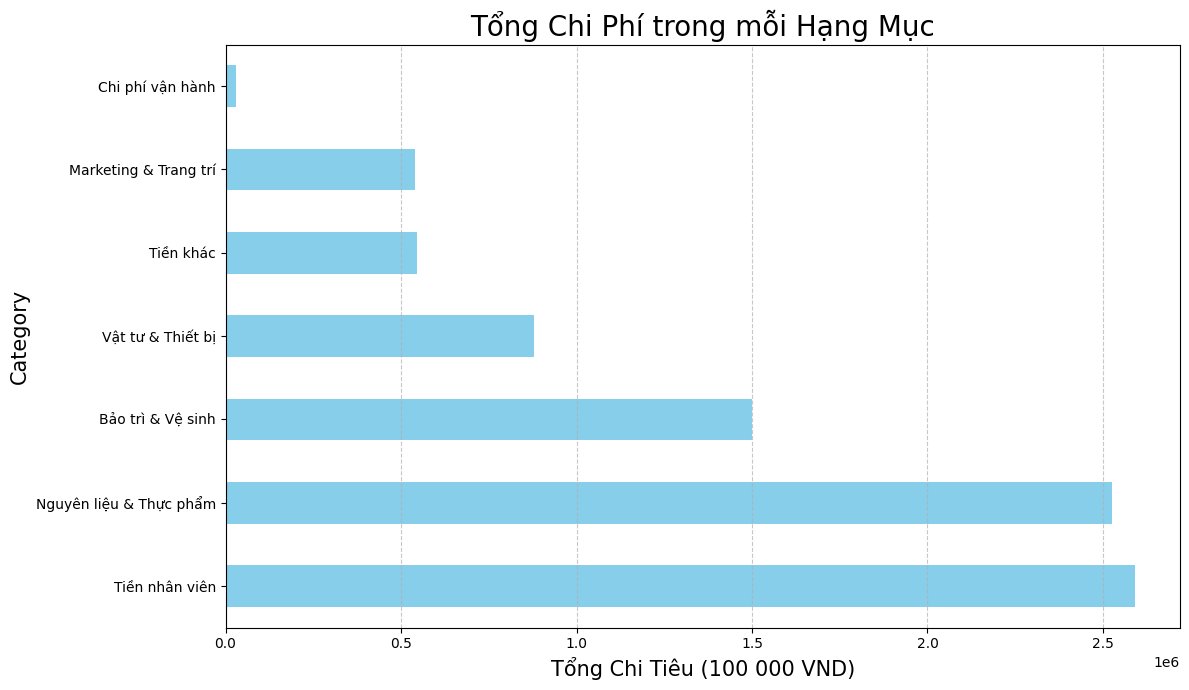

In [41]:
import matplotlib.pyplot as plt

# Create the bar chart
plt.figure(figsize=(12, 7))
category_totals.plot(kind='barh', color='skyblue') # Horizontal bar chart is nice here
plt.title('Tổng Chi Phí trong mỗi Hạng Mục', fontsize=20)
plt.xlabel('Tổng Chi Tiêu (100 000 VND)', fontsize=15)
plt.ylabel('Category', fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and show the chart
plt.savefig('expense_report_chart.png')
print("\nChart saved as 'expense_report_chart.png'")
plt.show()

The coffee shop spends the most on Employee Salary and importing ingrediences. Notice this is from our realistic mockup data

In [42]:
!pip install plotly

We will create a Sankey Diagram to quickly check where is our income coming from and how are we using the revenue to operate the coffee shop.

In [49]:
import pandas as pd
import plotly.graph_objects as go


# Getting the total cost
total_cost = category_totals.sum()
total_profit = total_revenue - total_cost
print(f"Revenue: {total_revenue:,.0f}, Cost: {total_cost:,.0f}, Profit: {total_profit:,.0f}")

# --- 2. DEFINE THE MULTI-LEVEL SANKEY STRUCTURE ---

# Create the master list of all nodes (labels)
main_labels = ['Tiền Chuyển Khoản/Thẻ', 'Tiền Mặt', 'Tổng Doanh Thu', 'Tổng Chi Phí', 'Lợi Nhuận']
cost_category_labels = category_totals.index.tolist()
labels = main_labels + cost_category_labels

# Define the links for the first part of the flow
sources = [0, 1, 2, 2] # From: [Card, Cash, Revenue, Revenue]
targets = [2, 2, 3, 4] # To:   [Revenue, Revenue, Cost, Profit]
values = [total_transfer, total_cash, total_cost, total_profit]

# Add the links for the cost breakdown
cost_source_node_index = 3 # The index of 'Tổng Chi Phí'
for i, amount in enumerate(category_totals):
    sources.append(cost_source_node_index)
    # The target index starts after the 5 main labels (at index 5)
    targets.append(len(main_labels) + i)
    values.append(amount)

# --- 3. CREATE AND DISPLAY THE CHART ---

fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=25,
      thickness=40,
      label=labels,
      hovertemplate='%{label}<extra></extra>'
    ),
    link=dict(
      source=sources,
      target=targets,
      value=values,
      hovertemplate='Dòng tiền từ %{source.label} đến %{target.label}<br>có giá trị là %{value:,.0f} VND<extra></extra>'
  ))])

fig.update_layout(
    title_text="Sơ Đồ Dòng Tiền Chi Tiết Quán Cafe",
    font_size=20
)

fig.show()

Revenue: 18,226,000, Cost: 8,609,000, Profit: 9,617,000


We can see the percentage of the cost per Categories

In [51]:
import plotly.express as px

# 1. Convert the Series to a DataFrame with 'Category' and 'Amount' columns
summary_df = category_totals.reset_index()

# 2. Create the treemap
fig = px.treemap(summary_df,
                 path=['Category'],  # The labels for the boxes
                 values='Amount',    # The values that determine box size
                 title='Proportional Breakdown of Cafe Expenses',
                 color='Amount',     # Color boxes based on amount
                 color_continuous_scale='Greens') # Choose a color scale

fig.show()

In [56]:
import plotly.graph_objects as go


# Create the donut chart
fig = go.Figure(data=[go.Pie(
    labels=category_totals.index,
    values=category_totals.values,
    hole= .3, # This creates the "donut" hole
    hovertemplate='<b>%{label}</b><br>%{percent} <br>Value: %{value:,.0f} VND<extra></extra>'
)])

fig.update_layout(
    title_text='Phần trăm chi tiêu theo Hạng Mục',
    title=dict(
        font=dict(
            size=20  # Adjust the size as needed
        )
    )
)

fig.show()

In [62]:
import plotly.graph_objects as go


# Create the funnel chart
fig = go.Figure(go.Funnel(
    y = ["Tổng Doanh Thu", "Tổng Chi Phí", "Lợi Nhuận"],
    x = [total_revenue, total_cost, total_profit],
    textinfo = "value+percent initial", # Show value and % of the starting amount
    marker = dict(color = ["#2196F3", "#FF9800", "#4CAF50"]) # Colors: Blue for Revenue, Orange for Cost, Green for Profit
))

fig.update_layout(
    title_text='Financial Funnel: From Revenue to Profit'
)

fig.show()